In [1]:
%reload_ext autoreload
%autoreload 2

from fastai import *
from fastai.vision import *
from pathlib import Path
import PIL
import cv2

from utils import *
from dark import *
from wrn4 import *

# from torch.utils.data.sampler import WeightedRandomSampler
from imba_sampler import ImbalancedDatasetSampler

torch.backends.cudnn.benchmark = False

In [2]:
MASKS = 'train.csv'

PATH = Path('./')

TRAIN = Path('train/')
TRAIN64 = Path('train64/')

TEST = Path('test/')

SAMPLE = Path('sample_submission.csv')

seg = pd.read_csv(PATH/MASKS)
sample_sub = pd.read_csv(PATH/SAMPLE)
train_names = list(seg.Id.values)
test_names = list(sample_sub.Id.values)

In [3]:
arch = Darknet([1,2,4,4,3], 28, 32, se=True)
# arch = wrn_22_10()

In [4]:
def open_image4d(path:PathOrStr)->Image:
    '''open RGBA image from 4 different 1-channel files.
    return: numpy array [4, sz, sz]'''
    path=str(path)
    flags = cv2.IMREAD_GRAYSCALE
    red = cv2.imread(path+ '_red.png', flags)
    blue = cv2.imread(path+ '_blue.png', flags)
    green = cv2.imread(path+ '_green.png', flags)
    yellow = cv2.imread(path+ '_yellow.png', flags)
    im = np.stack(([red, green, blue, yellow]))

    return Image(Tensor(im/255).float())

# def open_image4d(path:PathOrStr)->Image:
#     '''open RGBA image from a single 4-channel file
#     return: numpy array [4, sz, sz]'''
#     path=str(path)
#     flags = cv2.IMREAD_UNCHANGED
#     im = cv2.imread(path+ '.png', flags)
#     return Image(Tensor(np.rollaxis(im, 2, 0)/255).float())


In [5]:
fname = train_names[0]

In [6]:
%time im = open_image4d(TRAIN/fname); 

CPU times: user 13.8 ms, sys: 3.21 ms, total: 17.1 ms
Wall time: 16.3 ms


In [7]:
im.shape

torch.Size([4, 512, 512])

In [8]:
class Image4C_ds(ImageMultiDataset):
    def __init__(self, fns:FilePathList, labels:ImgLabels, classes:Optional[Collection[Any]]=None):
        super().__init__(fns, labels, classes)
    def __getitem__(self,i:int)->Tuple[Image, np.ndarray]: return open_image4d(self.x[i]), self.encode(self.y[i])
    def _get_x(self,i): return open_image4d(self.x[i])

In [9]:
from fastai.data_block import _extract_input_labels
fnames, labels = _extract_input_labels(seg, label_delim=' ')
test_fnames, _ = _extract_input_labels(sample_sub)

In [10]:
classes = uniqueify(np.concatenate(labels))

In [11]:
stats = ([0.485, 0.456, 0.406, 0.406], [0.229, 0.224, 0.225, 0.225])
norm,denorm = normalize_funcs(*stats)

In [12]:
tfms = get_transforms(do_flip=True, flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.2)

In [13]:
def get_data(sz=64, bs=64, is_test=False, pct = 0.1):
    folder=TRAIN
    test_ds=None
    if is_test: 
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
    train, val = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
    
    return ImageDataBunch.create(train_ds=train, valid_ds=val, test_ds=test_ds,
                                 ds_tfms=tfms, tfms=norm, bs=bs, size=sz)



def get_data_custom(sz=64, bs=128, pct = 0.1):
        folder=TRAIN
        t_names = [TEST/f for f in test_names]
        test_labels = [[classes[0]]] * len(test_names)
        test_ds = Image4C_ds(t_names, test_labels, classes)
        train_ds, val_ds = Image4C_ds.from_folder(PATH, folder, fnames, labels, valid_pct=pct, classes=classes)
        
        datasets = [train_ds,val_ds, test_ds]
        datasets = transform_datasets(*datasets, tfms=tfms, size=sz)
        sampler = ImbalancedDatasetSampler(datasets[0])
        train_dl = DataLoader(datasets[0], bs, sampler=sampler, num_workers=12)
        val_dl = DataLoader(datasets[1], 2*bs, False, num_workers=8)
        test_dl = DataLoader(datasets[2], 2*bs, False, num_workers=8)
        
        return ImageDataBunch(train_dl, val_dl, test_dl, path='.', device=None, tfms=norm, collate_fn=data_collate)


In [14]:
# train, val = Image4C_ds.from_folder(PATH, TRAIN, fnames, labels, valid_pct=0.2, classes=classes)

In [15]:
class_sample_count = array([12885,  1254,  3621,  1561,  1858,  2513,  1008,  2822,    53,
          45,    28,  1093,   688,   537,  1066,    21,   530,   210,
         902,  1482,   172,  3777,   802,  2965,   322,  8228,   328,
          11])
print(class_sample_count)

[12885  1254  3621  1561  1858  2513  1008  2822    53    45    28  1093   688   537  1066    21   530   210   902
  1482   172  3777   802  2965   322  8228   328    11]


In [16]:
def get_learner(data, focal=False, fp16=False):
    learn = Learner(data, arch , metrics=[accuracy_thresh, f1], loss_func=FocalLoss())
    if fp16: learn.to_fp16();
    return learn.mixup(stack_y=False)

# 64

In [17]:
data = get_data_custom(64, 160, 0.1)
learn = get_learner(data, focal=True, fp16=True)

In [ ]:
learn.lr_find()
learn.recorder.plot()

In [18]:
lr=1e-3

In [19]:
%time learn.fit_one_cycle(60, lr, wd=0.3, div_factor=10, pct_start=0.5)

Total time: 1:35:19
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      1.413175    1.398592    0.946191         0.169784  (01:32)
2      1.310520    1.412069    0.944243         0.250338  (01:31)
3      1.266928    1.467994    0.938004         0.133468  (01:31)
4      1.239145    1.376269    0.943303         0.210935  (01:32)
5      1.210323    1.328112    0.946474         0.228440  (01:30)
6      1.180299    1.312325    0.946429         0.223515  (01:31)
7      1.146095    1.486513    0.940484         0.300183  (01:32)
8      1.119640    1.338866    0.944107         0.241820  (01:31)
9      1.098099    1.319444    0.944073         0.222606  (01:32)
10     1.076862    1.245849    0.946146         0.247725  (01:31)
11     1.063730    1.230752    0.947199         0.282583  (01:31)
12     1.040744    1.232437    0.946010         0.219615  (01:32)
13     1.019219    1.262895    0.946213         0.279816  (01:31)
14     0.997047    1.383216    0.944798         0.281336  (01:31)

In [20]:
learn.save('dk_se_64_new')

# 128

In [31]:
data = get_data_custom(128, 96, 0.1)
learn = get_learner(data, focal=True, fp16=True)

In [32]:
learn.load('dk_se_64_new');

In [33]:
learn.freeze_to(4)

In [34]:
%time learn.fit_one_cycle(30, lr/3, wd=0.2, div_factor=10, pct_start=0.5)

Total time: 1:43:38
epoch  train_loss  valid_loss  accuracy_thresh  f1      
1      0.657698    0.664376    0.967097         0.601738  (03:29)
2      0.580034    0.640795    0.967933         0.618210  (03:18)
3      0.539213    0.622613    0.968734         0.628253  (03:18)
4      0.533896    0.615534    0.969175         0.636189  (04:32)
5      0.516086    0.607672    0.969243         0.636113  (03:18)
6      0.520268    0.605042    0.969299         0.638286  (03:18)
7      0.512072    0.597287    0.969525         0.640515  (03:18)
8      0.503374    0.595826    0.969344         0.642642  (03:18)
9      0.507537    0.596123    0.969491         0.649474  (03:18)
10     0.509768    0.600407    0.969683         0.650113  (03:18)
11     0.489126    0.585251    0.969864         0.656727  (03:17)
12     0.494773    0.589684    0.970180         0.656694  (03:18)
13     0.489900    0.583454    0.970327         0.654958  (03:18)
14     0.501965    0.593679    0.969898         0.656097  (03:18)

In [35]:
learn.save('dk_se_128_new')

# 256

In [111]:
data = get_data_custom(256, 24, 0.01)
learn = get_learner(data, focal=True, fp16=True)

In [112]:
# learn.layer_groups = split_model_idx(arch, [19,48,103, 158, -3])
learn.split((arch.layers[9],arch.layers[20]))

In [115]:
learn.load('dk_se_128_new'); len(learn.layer_groups)

3

In [114]:
# learn.freeze_to(-1)

In [ ]:
%time learn.fit_one_cycle(30, [1e-4, 1e-3/2, 1e-3], wd=0.3, div_factor=10, pct_start=0.3)

epoch,train_loss,valid_loss,accuracy_thresh,f1


In [ ]:
learn.save('dk_se_256_new');

# 512

In [110]:
data = get_data(508, 8, True, 0)

In [113]:
learn = get_learner(data, focal=True, fp16=True)

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/THCTensorCopy.cu:205

In [109]:
learn.load('dk_se_256_v2');

RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/generic/THCTensorCopy.cpp:20

In [106]:
learn.fit_one_cycle(5, 1e-5)

epoch,train_loss,valid_loss,accuracy_thresh,f1


RuntimeError: cuda runtime error (77) : an illegal memory access was encountered at /opt/conda/conda-bld/pytorch-nightly_1541670623625/work/aten/src/THC/generic/THCTensorMath.cu:24

In [22]:
learn.save('dk_se_512_v2')

# Validation and Preds

In [64]:
data = get_data(500, 16, True)
learn = get_learner(data, focal=True, fp16=False)

In [65]:
learn.load('dk_se_512_v2');

In [66]:
learn.model.float();

In [77]:
p1,t1 = learn.get_preds(ds_type=DatasetType.Test)

KeyboardInterrupt: 

In [68]:
p,t = learn.TTA(ds_type=DatasetType.Test)

Total time: 1:25:22



In [25]:
#valid data
# learn.data.valid_dl.add_tfm(to_half)
p_v, t_v = learn.get_preds()

In [71]:
np.save("preds500", to_np(p))

In [26]:
p_v.shape

torch.Size([1586, 28])

In [27]:
def f1_np(y_pred, y_true, threshold=0.5):
    y_pred = (y_pred>threshold).astype(int)
    TP = (y_pred*y_true).sum(1)
    prec = TP/(y_pred.sum(1)+1e-7)
    rec = TP/(y_true.sum(1)+1e-7)
    res = 2*prec*rec/(prec+rec+1e-7)
    return res.mean()

In [28]:
p_v_s = p_v.sigmoid()

In [29]:
f1(p_v, t_v)

tensor(0.6284)

In [30]:
p_v_np, t_v_np = to_np(p_v_s), to_np(t_v)

In [31]:
f1_np(p_v_np, t_v_np)

0.6283701845350824

In [32]:
def f1_n(y_pred, y_true, thresh, n, default=0.5):
    threshold = default * np.ones(y_pred.shape[1])
    threshold[n]=thresh
    return f1_np(y_pred, y_true, threshold)

In [33]:
def find_thresh(y_pred, y_true):
    ths = []
    for i in range(y_pred.shape[1]):
        aux = []
        for th in np.linspace(0,1,100):
            aux += [f1_n(y_pred, y_true, th, i)]
        ths += [np.array(aux).argmax()/100]
    return np.array(ths)

In [34]:
x = np.linspace(0,1,100)

In [35]:
y = np.array([f1_n(p_v_np, t_v_np, th, 1) for th in x])

In [36]:
import matplotlib.pyplot as plt

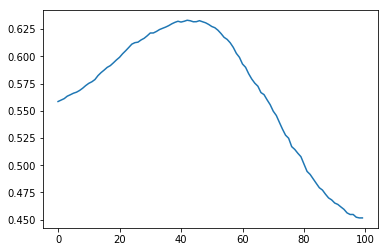

In [37]:
plt.plot(y)

In [41]:
ths = find_thresh(p_v_np, t_v_np); ths

array([0.61, 0.42, 0.36, 0.4 , 0.35, 0.43, 0.4 , 0.3 , 0.38, 0.26, 0.28, 0.36, 0.29, 0.38, 0.49, 0.55, 0.29, 0.51,
       0.27, 0.31, 0.48, 0.41, 0.2 , 0.46, 0.38, 0.73, 0.16, 0.4 ])

In [39]:
ths=array([0.56, 0.36, 0.48, 0.47, 0.47, 0.4 , 0.42, 0.41, 0.37, 0.36, 0.42, 0.48, 0.43, 0.49, 0.66, 0.37, 0.56, 0.31,
       0.26, 0.53, 0.71, 0.36, 0.24, 0.33, 0.29, 0.33, 0.33, 0.47])



In [42]:
f1_np(p_v_np, t_v_np, ths)

0.7020946345612924

# Sub File

In [40]:
preds = to_np(p.sigmoid())
threshold = ths
print(preds.shape)
classes = np.array(classes)
res = np.array([" ".join(classes[(np.where(pp>threshold))])for pp in preds])

(11702, 28)


In [41]:
classes

array(['16', '0', '7', '1', '2', '5', '18', '25', '23', '21', '24', '6', '11', '3', '12', '13', '14', '4', '20', '22',
       '17', '19', '8', '9', '10', '26', '27', '15'], dtype='<U2')

In [42]:
frame = pd.DataFrame(np.array([test_names, res]).T, columns = ['Id','Predicted'])
frame.to_csv('protein_se.csv', index=False)

In [43]:
frame.head()

,Id,Predicted
0,00008af0-bad0-11e8-b2b8-ac1f6b6435d0,3
1,0000a892-bacf-11e8-b2b8-ac1f6b6435d0,6
2,0006faa6-bac7-11e8-b2b7-ac1f6b6435d0,0 25 21
3,0008baca-bad7-11e8-b2b9-ac1f6b6435d0,0 26
4,000cce7e-bad4-11e8-b2b8-ac1f6b6435d0,23
